In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_train = (x_train - 127.5) / 127.5 # between [-1, 1]

In [4]:
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(BATCH_SIZE)

In [6]:
inp = Input(shape=(100,))
x = Dense(7*7*256)(inp)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Reshape((7,7,256))(x)
x = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same')(x) # (None, 7, 7, 128)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(x) # (None, 14, 14, 64)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
out = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh')(x) # (None, 28, 28, 1)

generator = Model(inp, out)

In [7]:
inp = Input(shape=(28,28,1))
x = Conv2D(64, (5,5), strides=(2,2), padding='same')(inp)
x = LeakyReLU()(x)
x = Dropout(.3)(x)
x = Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
x = LeakyReLU()(x)
x = Dropout(.3)(x)
x = Flatten()(x)
out = Dense(1)(x)

discriminator = Model(inp, out)

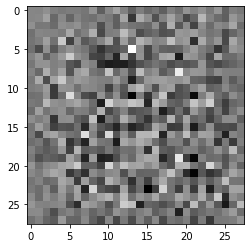

0.0019435139


In [8]:
noise = tf.random.normal((1,100))
generated_image = generator(noise, training=False)
plt.imshow(tf.reshape(generated_image, (28,28)), 'gray')
plt.show()
print(discriminator(generated_image).numpy()[0][0])

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
EPOCHS = 50

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal((BATCH_SIZE, 100))
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'epoch: {epoch}')
        for image_batch in dataset:
            train_step(image_batch)            

In [16]:
train(train_dataset, EPOCHS)

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49


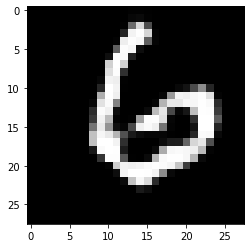

1.0860988


In [22]:
noise = tf.random.normal((1,100))
generated_image = generator(noise, training=False)
plt.imshow(tf.reshape(generated_image, (28,28)), 'gray')
plt.show()
print(discriminator(generated_image).numpy()[0][0])